In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
def draw_linear(
    x: np.ndarray, 
    y_actual: np.ndarray,
    w_actual: np.ndarray,
    y_predict: np.ndarray = None,
    w_predicted: np.ndarray = None
):
  linear_grid = np.linspace(x.min(), x.max(), 100)
  
  if y_predict is not None:
    plt.scatter(x, y_predict, label="predict")
  
  if w_predicted is not None:
    plt.plot(linear_grid, linear_grid * w_predicted[0] + w_predicted[1], label="predicted linear")
    
  plt.scatter(x, y_actual, label="true")
  plt.plot(linear_grid, linear_grid * w_actual[0] + w_actual[1], label="actual linear")

  plt.title("Dependecies")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend()

In [4]:
n_samples = 1024 * 4
n_features = 1
n_targets = 1

In [5]:
bias_actual = 32.
noise = 64

In [6]:
X, Y, coeff_actual = make_regression(
  n_samples=n_samples,
  n_features=n_features,
  n_informative=n_features, 
  n_targets=n_targets,
  coef=True,
  bias=bias_actual,
  noise=noise, random_state=42
)
coeff_actual = [coeff_actual.tolist()] if coeff_actual.shape == () else coeff_actual

Y = Y.reshape((Y.shape[0], 1))

In [7]:
X.shape, Y.shape

((4096, 1), (4096, 1))

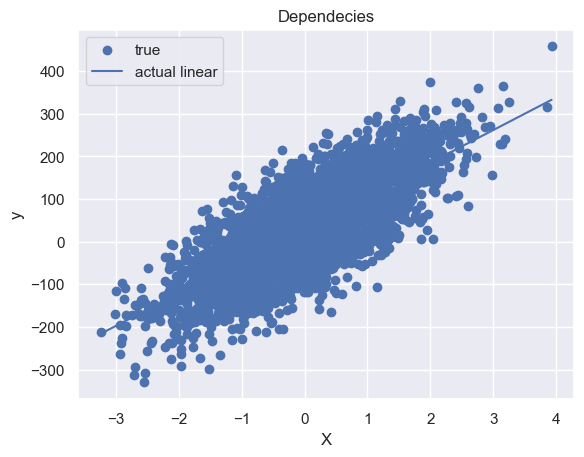

In [8]:
if n_features == 1 and n_targets == 1:
  draw_linear(X, Y, np.array([*coeff_actual, bias_actual]))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=42
)

In [10]:
n_clients = 50

In [11]:
%load_ext autoreload
%autoreload

In [12]:
from common.distributor import UniformDataDistributor, HomogenousDataDistributorComplex
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold

In [13]:
from function.vanilla import MSERidgeLinear, MSELassoLinear

In [61]:
distributor = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=n_clients,
  iid_fraction=0.3
)
mse = MSERidgeLinear(n_features=n_features)
model = Model(mse, distributor, save_history=True)

In [62]:
len(model.server.history), len(model.clients[0].history)

(0, 0)

In [63]:
model.clients.shape

(50,)

In [64]:
from common.pipeline import Pipeline


For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 32, 'eta': 0.0001}:
mse : 4339.049778015741
mae : 53.213250863217915
mape : 2.790707108411525

For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 128, 'eta': 0.0001}:
mse : 5157.600359602347
mae : 58.03205453544234
mape : 2.3187318954381224
done


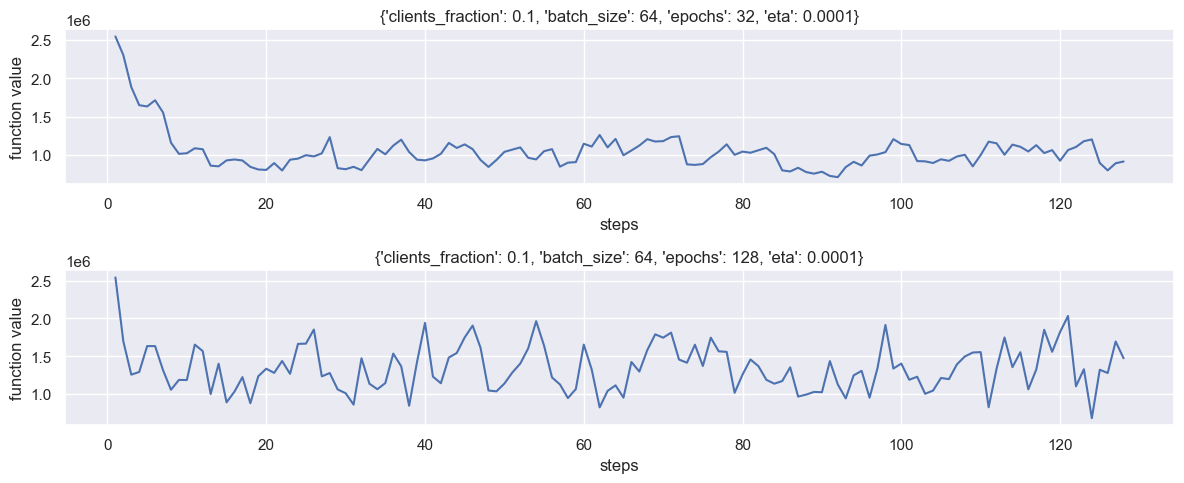

In [65]:
parameters = {
  "clients_fraction": [0.1],
  "batch_size": [64],
  "epochs": [32, 128],
  "rounds": [128],
  "eta": [1e-4],
}
metrics = {
  "mse" : mean_squared_error, 
  "mae" : mean_absolute_error, 
  "mape" : mean_absolute_percentage_error
}

pipeline = Pipeline(
  model=model,
  optimizer=FederatedAveraging,
  parameters=parameters,
  metrics=metrics,
  X_val=X_test,
  y_val=y_test
)

best, best_params = pipeline.run(
  choose_best_by="mae",
  show_global_history=True
)
print("done")

In [19]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[[76.72283947]
 [33.90838573]]
[[65.83822112]
 [22.62067512]]
[[74.682047  ]
 [27.45909594]]
[[66.07307089]
 [25.32232216]]
[[75.10915363]
 [33.61662818]]
[[79.60924818]
 [34.85411296]]
[[79.96910008]
 [34.52467961]]
[[82.29798113]
 [35.92632496]]
[[71.61672201]
 [32.64366246]]
[[80.58896035]
 [33.94503217]]
[[79.74171818]
 [34.17207014]]
[[65.3596913 ]
 [26.95665007]]
[[71.96724257]
 [31.17610822]]
[[81.91248724]
 [34.95257466]]
[[72.01928777]
 [31.14076487]]
[[80.59036642]
 [34.40103233]]
[[77.70141785]
 [33.28810336]]
[[78.66961984]
 [33.6782741 ]]
[[78.96748497]
 [33.28063328]]
[[74.87434723]
 [32.80593135]]
[[75.83245281]
 [32.31098702]]
[[59.91623304]
 [26.11778009]]
[[65.16694195]
 [27.69310107]]
[[72.12628185]
 [30.94323447]]
[[64.64578236]
 [29.6324874 ]]
[[74.3775457 ]
 [31.72638226]]
[[67.28901983]
 [28.89433196]]
[[76.06021473]
 [33.2072711 ]]
[[78.76666922]
 [32.49115148]]
[[76.37532802]
 [34.35953463]]
[[78.22760298]
 [33.24883564]]
[[80.99494479]
 [33.28877995]]
[[70.163

array([[64.15864637],
       [27.3173485 ]])

In [20]:
best_params

{'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 128, 'eta': 0.0001}

  MSE: 4522.266987300013
  MAE: 54.26704256032876
  MAPE: 2.627708507669918


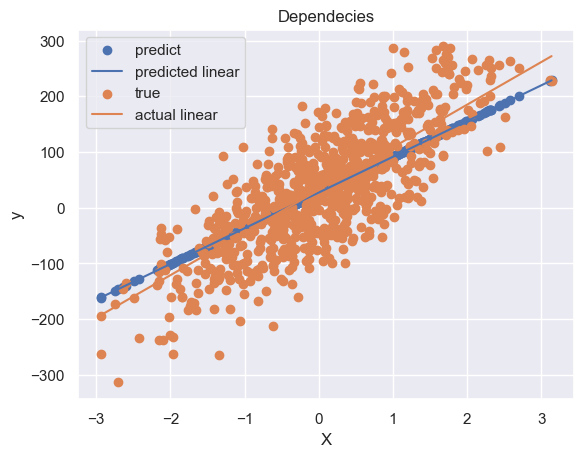

In [21]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X_test, y_test, np.array([*coeff_actual, bias_actual]),
    best.server.function.predict(X_test), best.server.function.weights()
  )
print(f"\
  MSE: {mean_squared_error(y_test, best.server.function.predict(X_test))}\n\
  MAE: {mean_absolute_error(y_test, best.server.function.predict(X_test))}\n\
  MAPE: {mean_absolute_percentage_error(y_test, best.server.function.predict(X_test))}\
")

In [22]:
def _by_norm2(data: np.ndarray):
  return np.linalg.norm(data, ord=2, axis=1)

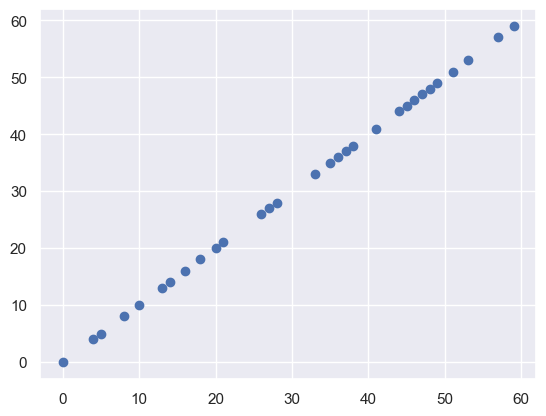

In [23]:
iid_fraction = 0.5
n_samples = 60

def _iid_size(total: int):
  return int(iid_fraction * total)

X = np.arange(0, n_samples).reshape((n_samples, 1))
y = np.arange(0, n_samples).reshape((n_samples, 1))

indices = np.arange(0, n_samples)
np.random.shuffle(indices)

iid = indices[:_iid_size(len(indices))]
X_iid = X[iid]
y_iid = y[iid]

plt.scatter(X_iid, y_iid)

In [24]:
non_iid = indices[_iid_size(len(indices)):]

y_non_iid = y[non_iid]
X_non_iid = X[non_iid]
sorted_non_iid = np.argsort(_by_norm2(y_non_iid))

y_non_iid = y_non_iid[sorted_non_iid]
X_non_iid = X_non_iid[sorted_non_iid]

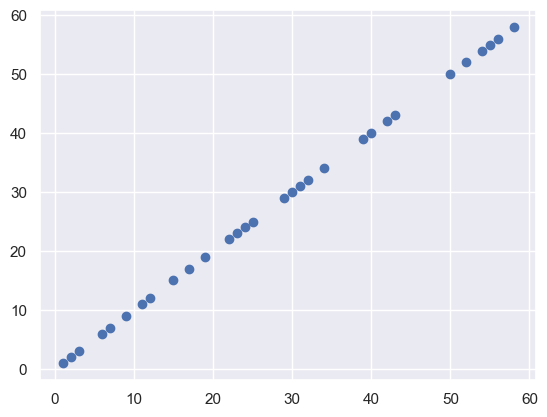

In [25]:
X_non_iid = X[non_iid]
y_non_iid = y[non_iid]
plt.scatter(X_non_iid, y_non_iid)

In [26]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from common.distributor import (
  UniformDataDistributor, HomogenousDataDistributor, HomogenousDataDistributorComplex
)
from optimization.federative.fedavg import FederatedAveraging
from optimization.federative.scaffold import Scaffold

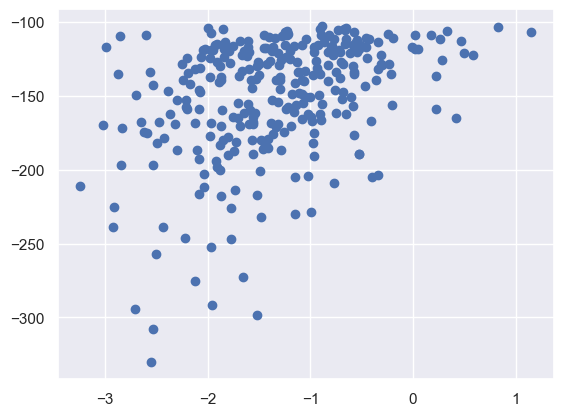

In [28]:
distrotest = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=10,
  iid_fraction=0
)
x, y = distrotest.server_portion()
plt.scatter(x, y)

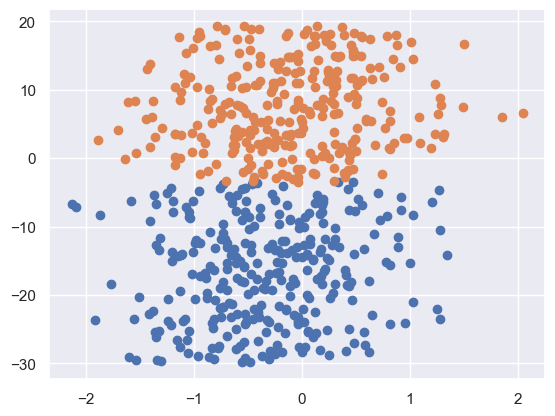

In [29]:
k = 0
for x, y in distrotest.clients_portions():
  if k == 2 or k == 3:
    plt.scatter(x, y)
  k += 1


In [30]:
import torch
from torch import nn

In [31]:
def check_weights(model: nn.Module):
  for i, parameters in enumerate(model.parameters()):
    print(f"\noriginal: {parameters=}\ntheory: {w[i]}\n---")

In [32]:
def step(model: nn.Module, theory_grads, w, old_w):
  with torch.no_grad():
    for i, parameters in enumerate(model.parameters()):
      w[i] -= 1e-3 * theory_grads[i](old_w[0], old_w[1], x, y)
      parameters -= 1e-3 * parameters.grad

In [33]:
theory_model_grad_loss_w1 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w2 * x
theory_model_grad_loss_w2 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w1 * x
theory_grads = [theory_model_grad_loss_w1, theory_model_grad_loss_w2]

In [34]:
model = nn.Sequential(
    nn.Linear(1, 1, bias=False), 
    nn.Linear(1, 1, bias=False), 
)
mse: nn.MSELoss = nn.MSELoss()
theory_model_loss = lambda w1, w2, x, y: (y - w1 * w2 * x) ** 2
mse

MSELoss()

In [35]:
w = [0. for _ in range(len(model))]
x = 1
y = 1

In [36]:
for i, parameters in enumerate(model.parameters()):
  w[i] = parameters.tolist()[0][0]
check_weights(model)


original: parameters=Parameter containing:
tensor([[-0.8766]], requires_grad=True)
theory: -0.8766436576843262
---

original: parameters=Parameter containing:
tensor([[0.2502]], requires_grad=True)
theory: 0.25017476081848145
---


In [37]:
predictions = model.forward(torch.Tensor([[x]]))
y_tensor =  torch.Tensor([[y]])

loss = mse(predictions, y_tensor)
loss, theory_model_loss(w[0], w[1], x, y)

(tensor(1.4867, grad_fn=<MseLossBackward0>), 1.4867269168524473)

In [38]:
loss.backward()

In [39]:
for theory_grad, parameters in zip(theory_grads, model.parameters()):
  print(f"{parameters=}")
  print(f"{parameters.grad=}")
  print(f"theory_grad: {theory_grad(w[0], w[1], x, y)}\n---")

parameters=Parameter containing:
tensor([[-0.8766]], requires_grad=True)
parameters.grad=tensor([[-0.6101]])
theory_grad: -0.6100832353583876
---
parameters=Parameter containing:
tensor([[0.2502]], requires_grad=True)
parameters.grad=tensor([[2.1378]])
theory_grad: 2.137807975459668
---


In [40]:
from copy import copy

old_w = copy(w)

In [41]:
step(model, theory_grads, w, old_w)

In [42]:
check_weights(model)


original: parameters=Parameter containing:
tensor([[-0.8760]], requires_grad=True)
theory: -0.8760335744489678
---

original: parameters=Parameter containing:
tensor([[0.2480]], requires_grad=True)
theory: 0.24803695284302177
---


In [43]:
model.zero_grad()

In [44]:
w[0] * x, w[1] * x

(-0.8760335744489678, 0.24803695284302177)

In [45]:
import torch

from torch import nn
from typing import List


class Flattener:
  def __init__(self, parameters_generator):
    self.shapes: List[torch.Size] = []

    parameters: nn.Parameter
    for parameters in parameters_generator:
      self.shapes.append(parameters.shape)

  def flatten(self, arrays: List[torch.Tensor]) -> np.ndarray:
    flat = np.array([])
    for array in arrays:
      flat = np.append(flat, array.numpy())

    return flat

  
  def unflatten(self, flat: np.ndarray) -> List[np.array]:
    arrays: List[torch.Tensor] = []
    
    start = 0
    for shape in self.shapes:
      arrays.append(torch.Tensor(flat[start : start + shape.numel()].reshape(shape)))
      
      start += shape.numel()

    return arrays

In [46]:
simple = nn.Sequential(
  nn.Linear(2, 1, bias=True),
  nn.Linear(1, 1, bias=True),
)
flattener = Flattener(simple.parameters())

loss = nn.MSELoss()
loss: torch.Tensor = simple.forward(torch.tensor([[1., 1.]]))
loss.backward()

updates: List[np.ndarray] = []
parameters_list: List[np.ndarray] = []

for parameters in simple.parameters():
  updates.append(parameters.grad.clone().detach())
  parameters_list.append(parameters.clone().detach())

In [47]:
flat_updates = flattener.flatten(updates)
flat_parameters_list = flattener.flatten(parameters_list)

In [48]:
flat_updates, flat_parameters_list

(array([-0.91267729, -0.91267729, -0.91267729, -0.07299209,  1.        ]),
 array([-0.59688079, -0.05466229,  0.57855099, -0.91267729, -0.88323534]))

In [49]:
all([(converted == actual).all() for converted, actual in zip(flattener.unflatten(flat_updates), updates)])

True

In [50]:
all([(converted == actual).all() for converted, actual in zip(flattener.unflatten(flat_parameters_list), parameters_list)])

True

In [51]:
parameters_list

[tensor([[-0.5969, -0.0547]]),
 tensor([0.5786]),
 tensor([[-0.9127]]),
 tensor([-0.8832])]

In [52]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [53]:
with torch.no_grad():
  for update, parameters in zip(flattener.unflatten(flat_updates), simple.parameters()):
    parameters += update

In [54]:
parameters_list = []
for parameters in simple.parameters():
  print(parameters)
  parameters_list.append(parameters.clone().detach().numpy())

Parameter containing:
tensor([[-1.5096, -0.9673]], requires_grad=True)
Parameter containing:
tensor([-0.3341], requires_grad=True)
Parameter containing:
tensor([[-0.9857]], requires_grad=True)
Parameter containing:
tensor([0.1168], requires_grad=True)


In [55]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [56]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [57]:
parameters_list

[array([[-1.5095581, -0.9673396]], dtype=float32),
 array([-0.3341263], dtype=float32),
 array([[-0.9856694]], dtype=float32),
 array([0.11676466], dtype=float32)]

In [58]:
array = np.arange(0, 3 * 4).reshape((3, 4))
array

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [59]:
array.flatten().reshape(array.shape)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])